### Library

In [33]:
import pandas as pd
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from mape import mean_absolute_percentage_error

from IPython.display import clear_output
from pandas import ExcelWriter

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from keras.layers import Dropout

from data_reshape import univariate_reshape

### Data Beban Historis

In [34]:
path = r'power_dataset.xlsx'
data = pd.read_excel (path)
a = 76
b = a-1
target = data.power.iloc[-a*24*7:-b*24*7]
target = target.reset_index(drop=True)
dataset = data.power.iloc[:-a*24*7]
dataset = pd.DataFrame(dataset)

In [35]:
# Normalize Dataset )
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

### Data Parameter yang akan diuji

In [36]:
path = r'LSTM_timesteps.xlsx'
df_par = pd.read_excel(path)
df_par

,Unnamed: 0,timesteps,feature,hidden_layer,RMSE,MAPE
0,0,1,168,1,0,0
1,1,2,168,1,0,0
2,2,3,168,1,0,0
3,3,4,168,1,0,0


Nama file saat disimpan :

In [37]:
algorithm_name = 'Revisi LSTM'
parameter_name = 'timesteps'

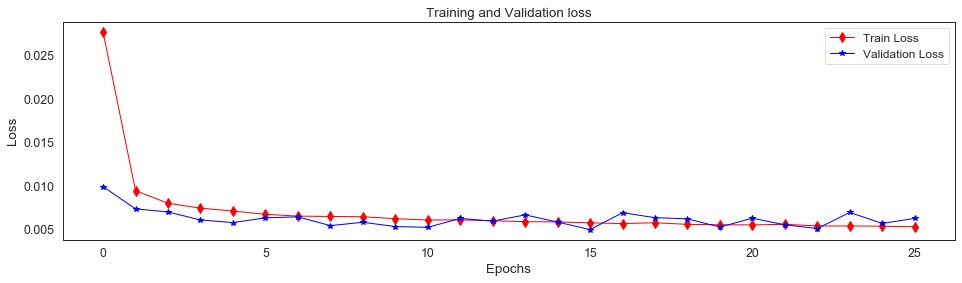

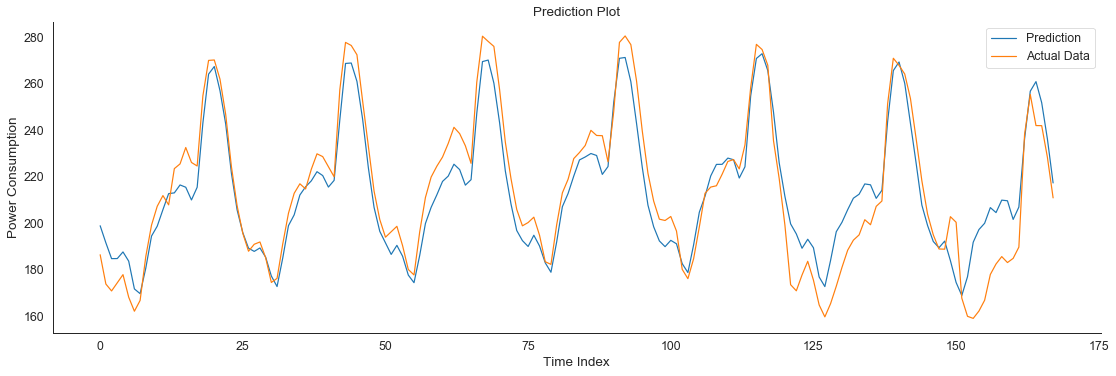

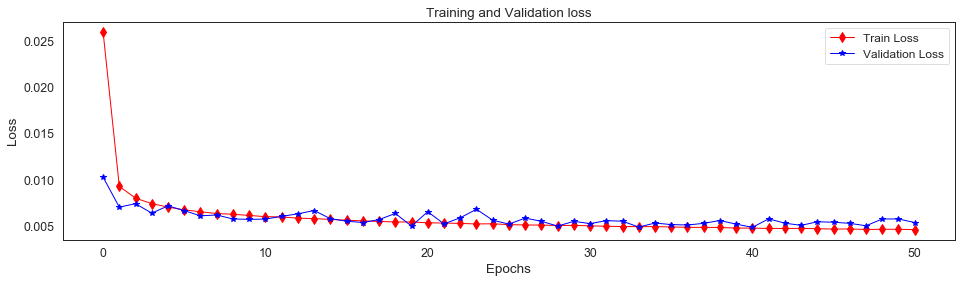

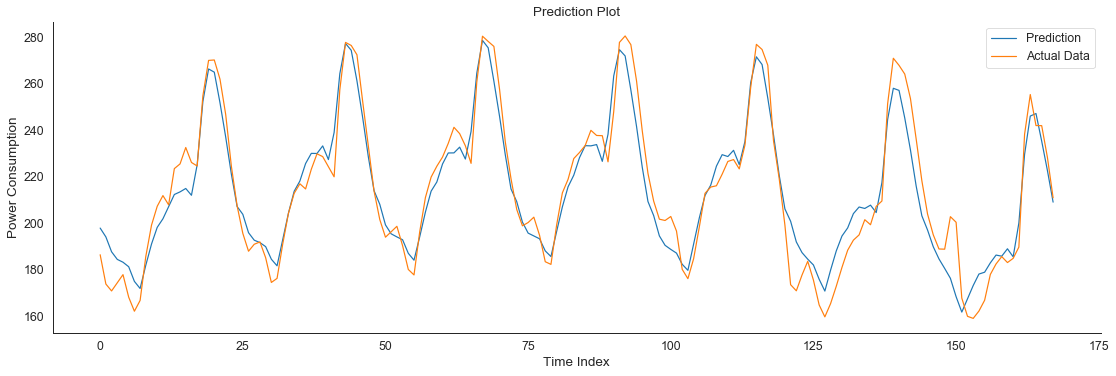

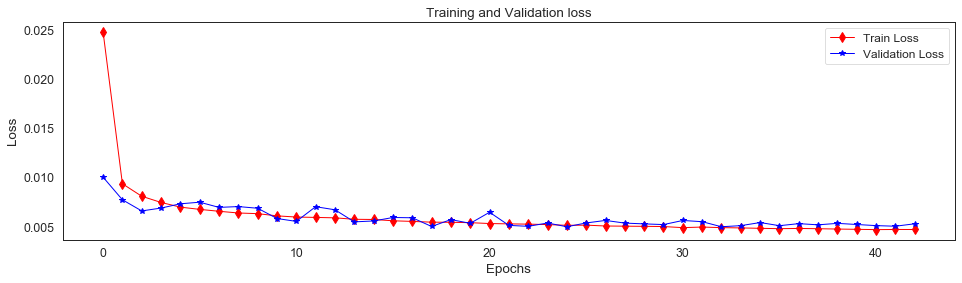

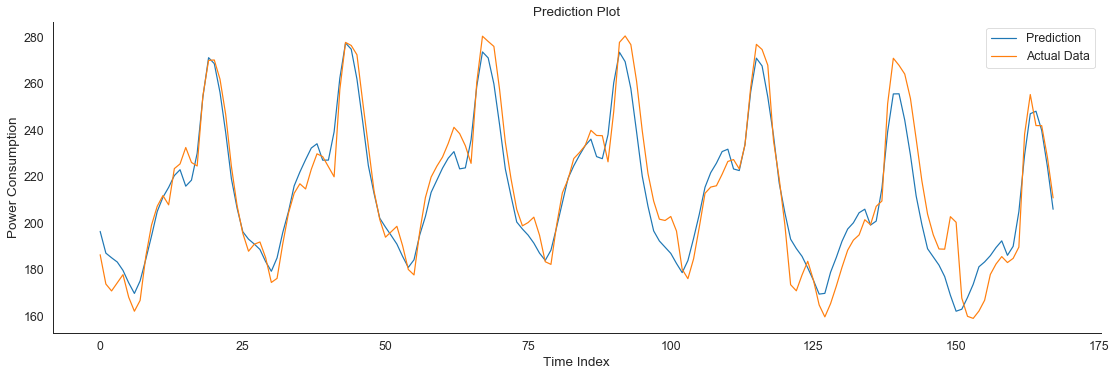

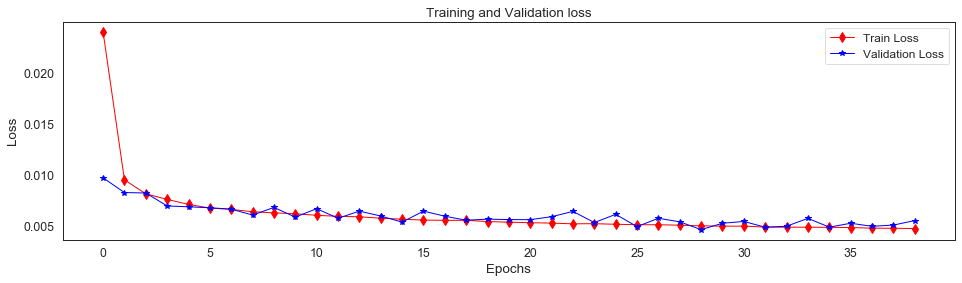

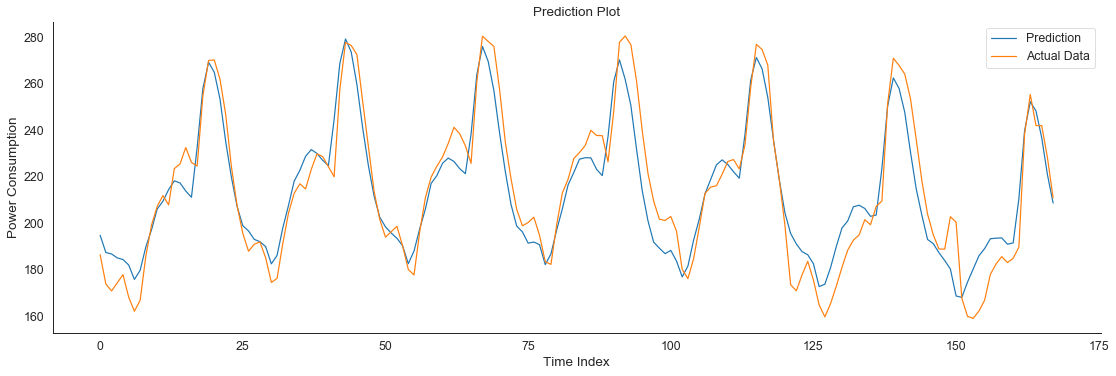

In [38]:
for i in range(len(df_par)):
    
    print("Running Model {}/{}\n".format(i,len(df_par)))
    in_steps = df_par.timesteps.iloc[i]
    in_features = df_par.feature.iloc[i]
    out_steps = 168
    train_x,train_y,test_sample = univariate_reshape(dataset,in_steps,in_features,out_steps,target)

    ##### Parameter LSTM 
    verbose = 1
    epochs = 500
    batch_size = 50
    neuron_layer_1 = in_features
    neuron_layer_2 = in_features
    neuron_layer_3 = in_features
    dropout_rate = 0.1
    
    print("Hidden Layer : {}\n".format(df_par.hidden_layer.iloc[i]))
    
    if df_par.hidden_layer.iloc[i] == 1:
        # Model LSTM
        model = Sequential()
        model.add(LSTM(neuron_layer_1, input_shape=(in_steps, in_features), return_sequences=False))
        model.add(Dropout(dropout_rate))
        model.add(Dense(out_steps))
    elif df_par.hidden_layer.iloc[i] == 2:
        # Model LSTM
        model = Sequential()
        model.add(LSTM(neuron_layer_1, input_shape=(in_steps, in_features), return_sequences=True))
        model.add(LSTM(neuron_layer_2,input_shape=(in_steps, in_features), return_sequences=False))
        model.add(Dropout(dropout_rate))
        model.add(Dense(out_steps))
    elif df_par.hidden_layer.iloc[i] == 3:
        # Model LSTM
        model = Sequential()
        model.add(LSTM(neuron_layer_1, input_shape=(in_steps, in_features), return_sequences=True))
        model.add(LSTM(neuron_layer_2,input_shape=(in_steps, in_features), return_sequences=True))
        model.add(LSTM(neuron_layer_3,input_shape=(in_steps, in_features)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(out_steps))

    model.compile(loss='mse', optimizer='adam')
    es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min',  restore_best_weights=True)
    history = model.fit(train_x, train_y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[es])

    # PLOT TRAIN and Validation LOSS
    sns.set_style('white')
    sns.set_context("paper", font_scale=1.4)  
    plt.figure(figsize=(16,4))
    plt.plot(history.history['loss'], color='r', linewidth=1, marker='d', markersize=7, label='Train Loss')
    plt.plot(history.history['val_loss'], color='b',linewidth=1, marker='*',markersize=6, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation loss')
    legend = plt.legend(loc='upper right',prop={'size': 12})
    plt.savefig('{} parameter {} model number {} - loss.png'.format(parameter_name, algorithm_name,i), dpi=500)

    predict = model.predict(test_sample)
    predict = scaler.inverse_transform(predict)

    #DATA PREDICTION
    plt.figure(figsize=(16,5))
    plt.plot(predict[0], label = "Prediction")
    plt.plot(target, label = "Actual Data")
    plt.tick_params(left=False, labelleft=True) #remove ticks
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.xlabel('Time Index')
    plt.ylabel('Power Consumption')
    plt.legend(loc='upper right')
    plt.title('Prediction Plot')
    plt.savefig('{} parameter {} model number {} - Prediction Plot.png'.format(parameter_name, algorithm_name,i), dpi=500)
    
    #Mengisi dataframe
    df_par.RMSE.iloc[i] = np.sqrt(mean_squared_error(target,predict[0]))
    df_par.MAPE.iloc[i] = mean_absolute_percentage_error(target,predict[0])

    # serialize model to JSON
    model_json = model.to_json()
    with open("{} parameter {} model number {}.json".format(parameter_name, algorithm_name,i), "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    model.save_weights("{} parameter {} model number {}.h5".format(parameter_name, algorithm_name,i))
    
    from pandas import ExcelWriter
    writer = ExcelWriter('{} {} Parameter Autosave Progress.xlsx'.format(algorithm_name,parameter_name))
    df_par.to_excel(writer,'Sheet1')
    writer.save()
    
    print("")
    print("Resetting Model..")
    model.reset_states()
    
    clear_output(wait=False)
    

Menyimpan data ke excel

In [39]:
writer = ExcelWriter('{} {} finish.xlsx'.format(algorithm_name,parameter_name))
df_par.to_excel(writer,'Sheet1')
writer.save()
print('complete')

complete
